# Data Prepration & Cleaning

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime 

sns.set_style("whitegrid")
%matplotlib inline

## 1. Get Data ([Data Source](https://dev.socrata.com/foundry/data.cityofnewyork.us/h9gi-nx95))

In [10]:
from sodapy import Socrata

# Client Initialization (fill in your credentials) [Optional]
client = Socrata("data.cityofnewyork.us",
                 app_token="",
                 username="",
                 password="")

results = client.get("h9gi-nx95",
                      where="crash_date >= '2022-01-01' AND crash_date < '2026-01-01'",
                      limit=1000000)

data = pd.DataFrame.from_records(results)
data.to_csv("../data/nyc_crash_data.csv", index=False)
print("Saved data to ../data/nyc_crash_data.csv")

Saved data to ../data/nyc_crash_data.csv


# 2. Load Raw Data

In [12]:
df_raw = pd.read_csv("../data/nyc_crash_data.csv")

print(f"Raw dataset shape: {df_raw.shape}")
print(f"\nColumns: {df_raw.columns.tolist()}")
print(f"\nFirst 3 rows:")
df_raw.head(3)

Raw dataset shape: (368339, 29)

Columns: ['crash_date', 'crash_time', 'latitude', 'longitude', 'location', 'on_street_name', 'number_of_persons_injured', 'number_of_persons_killed', 'number_of_pedestrians_injured', 'number_of_pedestrians_killed', 'number_of_cyclist_injured', 'number_of_cyclist_killed', 'number_of_motorist_injured', 'number_of_motorist_killed', 'contributing_factor_vehicle_1', 'contributing_factor_vehicle_2', 'collision_id', 'vehicle_type_code1', 'off_street_name', 'vehicle_type_code2', 'borough', 'zip_code', 'cross_street_name', 'contributing_factor_vehicle_3', 'vehicle_type_code_3', 'contributing_factor_vehicle_4', 'contributing_factor_vehicle_5', 'vehicle_type_code_4', 'vehicle_type_code_5']

First 3 rows:


,crash_date,crash_time,latitude,longitude,location,on_street_name,number_of_persons_injured,number_of_persons_killed,number_of_pedestrians_injured,number_of_pedestrians_killed,...,vehicle_type_code2,borough,zip_code,cross_street_name,contributing_factor_vehicle_3,vehicle_type_code_3,contributing_factor_vehicle_4,contributing_factor_vehicle_5,vehicle_type_code_4,vehicle_type_code_5
0,2022-01-01T00:00:00.000,7:33,40.771477,-73.91824,"{'latitude': '40.771477', 'longitude': '-73.91...",HOYT AVENUE NORTH,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2022-01-01T00:00:00.000,4:30,NaN,NaN,NaN,Southern parkway,0,0,0,0,...,Sedan,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2022-01-01T00:00:00.000,7:57,NaN,NaN,NaN,WESTCHESTER AVENUE,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# 3. Parse Timestamps

In [13]:
# Parse crash_date and crash_time into a single datetime column
df_raw['crash_datetime'] = pd.to_datetime(
    df_raw['crash_date'].str[:10] + ' ' + df_raw['crash_time'],
    format='%Y-%m-%d %H:%M',
    errors='coerce'
)

# Check for parsing failures
n_invalid_datetime = df_raw['crash_datetime'].isna().sum()
print(f"Invalid datetime entries: {n_invalid_datetime} ({n_invalid_datetime/len(df_raw)*100:.2f}%)")

# Show some examples of parsed datetimes
print(f"\nSample parsed datetimes:")
df_raw[['crash_date', 'crash_time', 'crash_datetime']].head(5)

Invalid datetime entries: 0 (0.00%)

Sample parsed datetimes:


,crash_date,crash_time,crash_datetime
0,2022-01-01T00:00:00.000,7:33,2022-01-01 07:33:00
1,2022-01-01T00:00:00.000,4:30,2022-01-01 04:30:00
2,2022-01-01T00:00:00.000,7:57,2022-01-01 07:57:00
3,2022-01-01T00:00:00.000,5:17,2022-01-01 05:17:00
4,2022-01-01T00:00:00.000,1:30,2022-01-01 01:30:00


## 4. Filter Invalid Records

Drop rows with missing:
- `crash_datetime`
- `latitude`
- `longitude`

In [14]:
# Count missing values before filtering
print("Missing values before filtering:")
print(f"  crash_datetime: {df_raw['crash_datetime'].isna().sum()}")
print(f"  latitude: {df_raw['latitude'].isna().sum()}")
print(f"  longitude: {df_raw['longitude'].isna().sum()}")
print(f"  Total rows: {len(df_raw)}")

# Filter to valid records
df = df_raw.dropna(subset=['crash_datetime', 'latitude', 'longitude']).copy()

print(f"\nRows after filtering: {len(df)} (retained {len(df)/len(df_raw)*100:.2f}%)")

Missing values before filtering:
  crash_datetime: 0
  latitude: 24155
  longitude: 24155
  Total rows: 368339

Rows after filtering: 344184 (retained 93.44%)


## 5. Detect Geographic Outliers

NYC bounding box:
- Latitude: 40.477 to 40.917
- Longitude: -74.259 to -73.700

Geographic outliers detected: 4435 (1.29%)

Example outliers:
          crash_datetime  latitude  longitude   borough
690  2022-01-04 07:42:00       0.0        0.0     BRONX
771  2022-01-04 06:00:00       0.0        0.0       NaN
789  2022-01-04 13:22:00       0.0        0.0  BROOKLYN
1252 2022-01-06 16:09:00       0.0        0.0     BRONX
2277 2022-01-10 22:34:00       0.0        0.0  BROOKLYN

Rows after removing geographic outliers: 339749


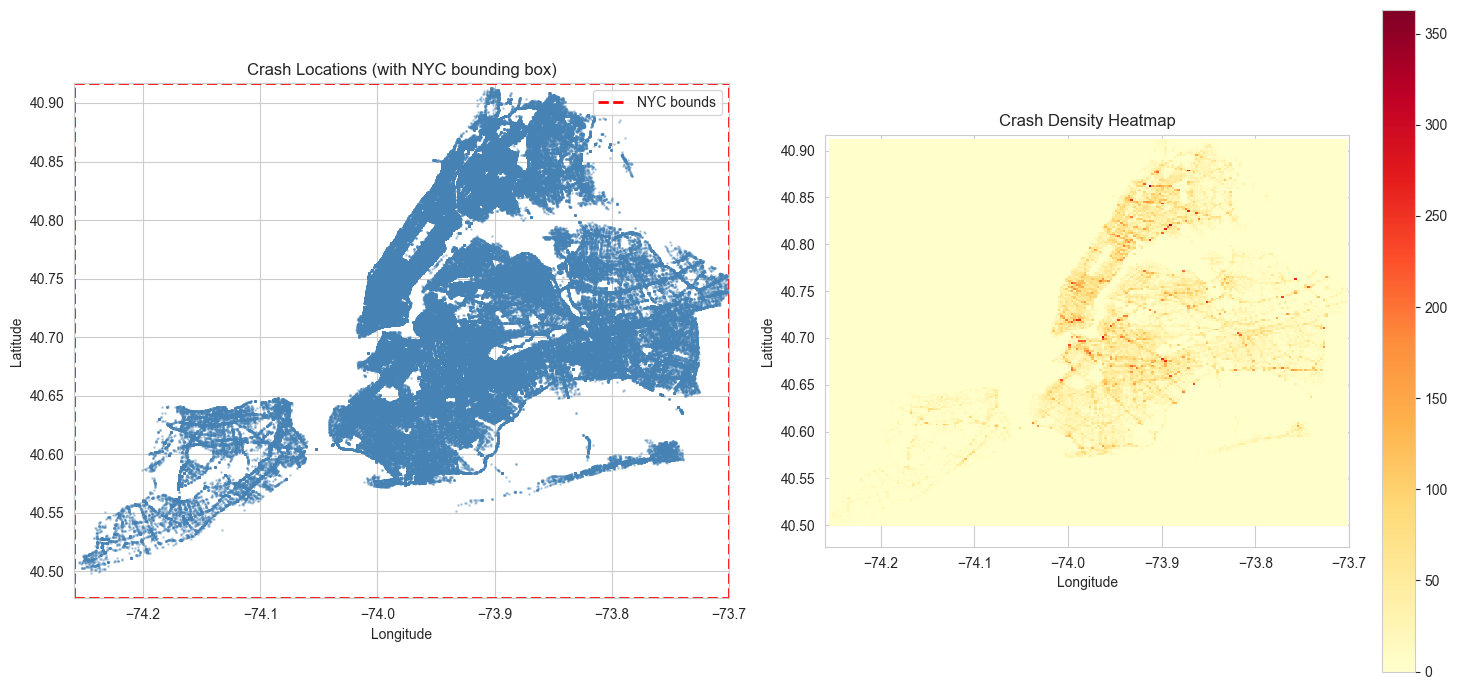

In [15]:
# Define NYC bounding box
NYC_LAT_MIN, NYC_LAT_MAX = 40.477, 40.917
NYC_LON_MIN, NYC_LON_MAX = -74.259, -73.700

# Identify outliers
geo_outliers = (
    (df['latitude'] < NYC_LAT_MIN) | (df['latitude'] > NYC_LAT_MAX) |
    (df['longitude'] < NYC_LON_MIN) | (df['longitude'] > NYC_LON_MAX)
)

print(f"Geographic outliers detected: {geo_outliers.sum()} ({geo_outliers.sum()/len(df)*100:.2f}%)")

# Show outlier examples
if geo_outliers.sum() > 0:
    print("\nExample outliers:")
    print(df[geo_outliers][['crash_datetime', 'latitude', 'longitude', 'borough']].head(5))

# Filter out geographic outliers
df = df[~geo_outliers].copy()
print(f"\nRows after removing geographic outliers: {len(df)}")
    
# Visualize lat/lon distribution AFTER removing outliers
fig, axes = plt.subplots(1, 2, figsize=(15, 7))

# Left plot – scatter of individual crashes
axes[0].scatter(df['longitude'], df['latitude'], 
                s=1, alpha=0.3, color='steelblue')
axes[0].axhline(NYC_LAT_MIN, color='red', linestyle='--', linewidth=2, label='NYC bounds')
axes[0].axhline(NYC_LAT_MAX, color='red', linestyle='--', linewidth=2)
axes[0].axvline(NYC_LON_MIN, color='red', linestyle='--', linewidth=2)
axes[0].axvline(NYC_LON_MAX, color='red', linestyle='--', linewidth=2)
axes[0].set_xlabel('Longitude')
axes[0].set_ylabel('Latitude')
axes[0].set_title('Crash Locations (with NYC bounding box)')
axes[0].legend()

# Right plot – density heatmap
im = axes[1].hist2d(df['longitude'], df['latitude'], bins=200, cmap='YlOrRd')
axes[1].set_xlabel('Longitude')
axes[1].set_ylabel('Latitude')
axes[1].set_title('Crash Density Heatmap')
plt.colorbar(im[3], ax=axes[1]) 

for ax in axes:
    ax.set_xlim(NYC_LON_MIN, NYC_LON_MAX)   
    ax.set_ylim(NYC_LAT_MIN, NYC_LAT_MAX)
    ax.set_aspect('equal', adjustable='box') 

plt.tight_layout()
plt.show()

## 6. Detect Temporal Outliers

Date range: 2022-01-01 00:00:00 to 2025-11-25 23:58:00

Temporal outliers: 0 (0.00%)

Rows after removing temporal outliers: 339749


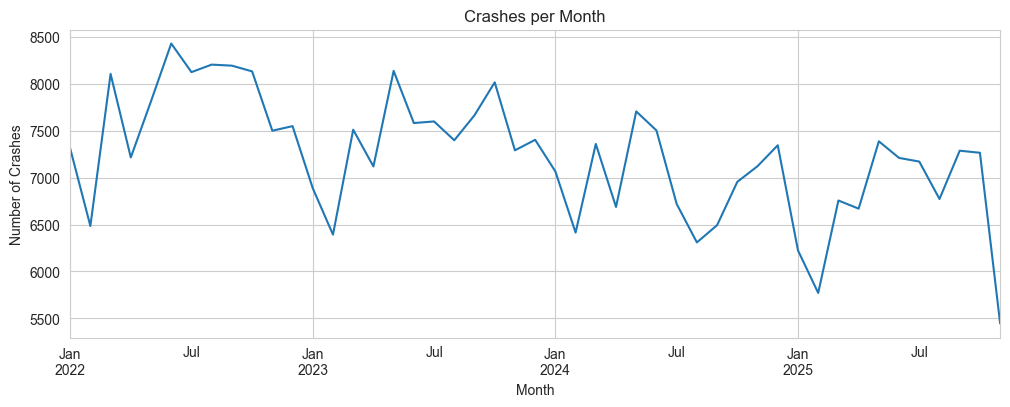

In [16]:
# Check date range
print(f"Date range: {df['crash_datetime'].min()} to {df['crash_datetime'].max()}")

# Define valid date range (2022-2025)
VALID_START = pd.Timestamp('2022-01-01')
VALID_END = pd.Timestamp('2025-12-31')

temporal_outliers = (df['crash_datetime'] < VALID_START) | (df['crash_datetime'] > VALID_END)

print(f"\nTemporal outliers: {temporal_outliers.sum()} ({temporal_outliers.sum()/len(df)*100:.2f}%)")

if temporal_outliers.sum() > 0:
    print("\nExample temporal outliers:")
    print(df[temporal_outliers][['crash_datetime', 'latitude', 'longitude']].head(5))

# Filter out temporal outliers
df = df[~temporal_outliers].copy()
print(f"\nRows after removing temporal outliers: {len(df)}")

# Plot crashes over time
crashes_per_month = df.groupby(df['crash_datetime'].dt.to_period('M')).size()
crashes_per_month.plot(figsize=(12, 4), title='Crashes per Month')
plt.xlabel('Month')
plt.ylabel('Number of Crashes')
plt.grid(True)
plt.show()

## 7. Check Severity Anomalies

Injury/Death Statistics:
  Total injuries: 188144
  Total deaths: 914
  Crashes with injuries: 141069 (41.52%)
  Crashes with deaths: 875 (0.26%)

Crashes with >10 injuries: 52

Severe crashes (>10 injuries):
            crash_datetime   latitude  longitude  number_of_persons_injured  \
17125  2022-03-07 10:00:00  40.646442 -74.078840                         13   
38131  2022-05-18 09:10:00  40.699930 -73.961880                         13   
41098  2022-05-28 22:30:00  40.653984 -73.927704                         15   
54917  2022-07-12 22:16:00  40.812950 -73.884180                         14   
61572  2022-08-04 08:25:00  40.839590 -73.882680                         13   
67697  2022-08-25 09:20:00  40.683582 -73.953964                         15   
87512  2022-11-01 18:30:00  40.637768 -73.958680                         11   
88345  2022-11-04 08:51:00  40.689070 -73.921310                         11   
104346 2023-01-02 20:59:00  40.867012 -73.923120                         21   
1

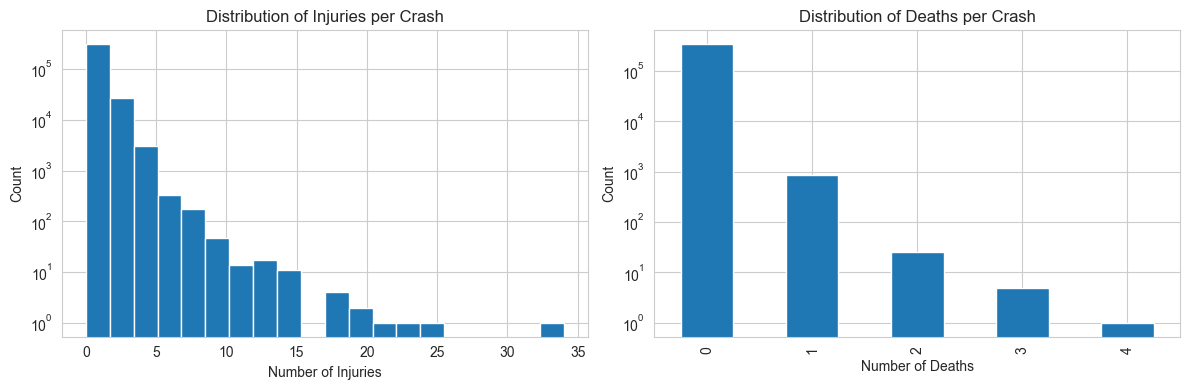

In [17]:
# Check injury/death statistics
print("Injury/Death Statistics:")
print(f"  Total injuries: {df['number_of_persons_injured'].sum()}")
print(f"  Total deaths: {df['number_of_persons_killed'].sum()}")
print(f"  Crashes with injuries: {(df['number_of_persons_injured'] > 0).sum()} ({(df['number_of_persons_injured'] > 0).sum()/len(df)*100:.2f}%)")
print(f"  Crashes with deaths: {(df['number_of_persons_killed'] > 0).sum()} ({(df['number_of_persons_killed'] > 0).sum()/len(df)*100:.2f}%)")

# Flag crashes with >10 injuries (possible data errors or major incidents)
severe_crashes = df['number_of_persons_injured'] > 10
print(f"\nCrashes with >10 injuries: {severe_crashes.sum()}")

if severe_crashes.sum() > 0:
    print("\nSevere crashes (>10 injuries):")
    print(df[severe_crashes][['crash_datetime', 'latitude', 'longitude', 'number_of_persons_injured', 'number_of_persons_killed', 'borough']].head(10))

# Distribution of injuries
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

df['number_of_persons_injured'].hist(bins=20, ax=axes[0])
axes[0].set_xlabel('Number of Injuries')
axes[0].set_ylabel('Count')
axes[0].set_title('Distribution of Injuries per Crash')
axes[0].set_yscale('log')

df['number_of_persons_killed'].value_counts().sort_index().plot(kind='bar', ax=axes[1])
axes[1].set_xlabel('Number of Deaths')
axes[1].set_ylabel('Count')
axes[1].set_title('Distribution of Deaths per Crash')
axes[1].set_yscale('log')

plt.tight_layout()
plt.show()

# Keep all crashes (including severe ones) - they are valid data points

## 8. Final Cleaning & Save

In [18]:
# Select relevant columns for downstream analysis
columns_to_keep = [
    'collision_id',
    'crash_datetime',
    'latitude',
    'longitude',
    'borough',
    'zip_code',
    'number_of_persons_injured',
    'number_of_persons_killed',
    'number_of_pedestrians_injured',
    'number_of_pedestrians_killed',
    'number_of_cyclist_injured',
    'number_of_cyclist_killed',
    'number_of_motorist_injured',
    'number_of_motorist_killed',
    'contributing_factor_vehicle_1',
    'vehicle_type_code1'
]

df_clean = df[columns_to_keep].copy()

# Save cleaned dataset
df_clean.to_csv('../data/crashes_cleaned.csv', index=False)
print(f"✓ Saved cleaned dataset to ../data/crashes_cleaned.csv")
print(f"  Final shape: {df_clean.shape}")

✓ Saved cleaned dataset to ../data/crashes_cleaned.csv
  Final shape: (339749, 16)


## 9. Data Quality Summary

In [19]:
print("=" * 60)
print("DATA QUALITY SUMMARY")
print("=" * 60)
print(f"Raw dataset rows:              {len(df_raw):>10,}")
print(f"Missing lat/lon/datetime:      {len(df_raw) - len(df):>10,} ({(len(df_raw) - len(df))/len(df_raw)*100:>5.2f}%)")
print(f"Geographic outliers removed:   {geo_outliers.sum():>10,} ({geo_outliers.sum()/len(df)*100:>5.2f}%)")
print(f"Temporal outliers removed:     {temporal_outliers.sum():>10,} ({temporal_outliers.sum()/len(df)*100:>5.2f}%)")
print(f"-" * 60)
print(f"Final cleaned dataset:         {len(df_clean):>10,} ({len(df_clean)/len(df_raw)*100:>5.2f}% retention)")
print("=" * 60)
print(f"\nDate range: {df_clean['crash_datetime'].min()} to {df_clean['crash_datetime'].max()}")
print(f"Total injuries: {df_clean['number_of_persons_injured'].sum():,}")
print(f"Total deaths: {df_clean['number_of_persons_killed'].sum():,}")
print("\n✓ Data cleaning complete!")

DATA QUALITY SUMMARY
Raw dataset rows:                 368,339
Missing lat/lon/datetime:          28,590 ( 7.76%)
Geographic outliers removed:        4,435 ( 1.31%)
Temporal outliers removed:              0 ( 0.00%)
------------------------------------------------------------
Final cleaned dataset:            339,749 (92.24% retention)

Date range: 2022-01-01 00:00:00 to 2025-11-25 23:58:00
Total injuries: 188,144
Total deaths: 914

✓ Data cleaning complete!
